In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

In [2]:
def process_data(file_path):
    data = pd.read_csv(file_path)
    max_index = data['Temperature_measured'].idxmax() + 1
    temperature = np.array(data['Temperature_measured'].iloc[:max_index - 10])
    voltage = np.array(data['Voltage_measured'].iloc[:max_index - 10])
    time = np.array(data['Time'].iloc[:max_index - 10])
    current = 2
    power = current * voltage * time/3600

    return power, temperature

In [3]:
def fit_polynomial(input_data, output_data, order):
    model = LinearRegression()
    poly_features = PolynomialFeatures(degree = order, include_bias = True)
    input_features = poly_features.fit_transform(input_data.reshape(-1, 1))
    
    model.fit(input_features, output_data)
    temperature_predicted = model.predict(input_features)
    coefficients = np.concatenate(([model.intercept_], model.coef_[1:]))
    
    return temperature_predicted, coefficients 

In [4]:
def plot_comparison(power, temperature, temperature_predicted):
    plt.scatter(power, temperature, color = 'red', marker = 'x', s = 10)
    plt.plot(power, temperature_predicted, color = 'blue')
    plt.xlabel("Power (W)")
    plt.ylabel("Temperature (C)")
    plt.title("Power vs Temperature")
    plt.show()
    plt.close()

In [16]:
def analyze_data(order, folder_path, folder_output):
    csv_files = [file for file in os.listdir(folder_path) if file.endswith(".csv")]
    csv_files.sort(key=lambda x: int(x.split("_")[-1].split(".")[0]))
    params = []

    for file in csv_files:
        file_path = os.path.join(folder_path, file)
        power, temperature = process_data(file_path)
        temperature_predicted, weights = fit_polynomial(power, temperature, order)
        #plot_comparison(power, temperature, temperature_predicted)
        params.append(weights)
        
    columns = [f"w{i+1}" for i in range(order+1)]
    data = pd.DataFrame(params, columns = columns)
    output_file_name = os.path.join(folder_output, "Temp_Params.csv")
    data.to_csv(output_file_name, index=False)
    print("Params successfully saved")

Params successfully saved


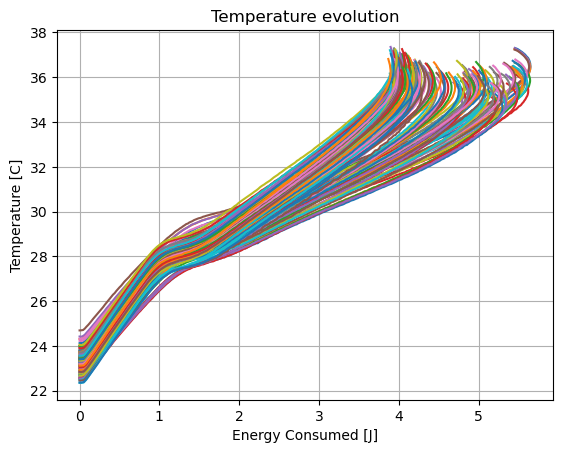

In [17]:
analyze_data(3, "datasets/battery_18/Discharge", "datasets/battery_18")

## **Params viz**

In [12]:
def plot_weights(csv_file):
    data = pd.read_csv(csv_file)
    num_weights = len(data.columns)
    
    for i in range(num_weights):
        plt.figure(figsize=(10, 6))
        plt.scatter(range(len(data)), data.iloc[:, i], label=f"Weight {i + 1}", marker='o')
        plt.title(f"Weight {i + 1} Across Different Datasets")
        plt.xlabel("Discharging Cycles")
        plt.ylabel(f"Weight {i + 1}")
        plt.legend(loc="upper right")
        plt.grid(True)
        plt.show()

In [13]:
plot_weights("datasets/battery_6/Temp_Params.csv")

In [20]:
def fit_polynomial_with_bias(input_data, output_data, order):
    model = LinearRegression()
    poly_features = PolynomialFeatures(degree = order, include_bias = True)
    input_features = poly_features.fit_transform(input_data.reshape(-1, 1))
    
    model.fit(input_features, output_data)
    voltage_predicted = model.predict(input_features)
    coefficients = np.concatenate(([model.intercept_], model.coef_[1:]))
    
    return voltage_predicted, coefficients

def estimate_parameters_degradation(order, csv_file, folder_output):
    data = pd.read_csv(csv_file)
    num_weights = len(data.columns)
    degradation_params = []
    
    for i in range(num_weights):
        w_i = data.iloc[:, i]
        discharge_cycles = np.array(range(1,len(w_i)+1))
        
        #training_data = filter_training_data(discharge_cycles, viable_data)
        w_i_estimation, params = fit_polynomial_with_bias(discharge_cycles, w_i, order)

        degradation_params.append(params)
        
        plt.figure(figsize = (10,6))
        plt.scatter(discharge_cycles, w_i, marker = "x", color = "red")
        plt.plot(discharge_cycles, w_i_estimation, color = "blue")
        plt.show()

    columns = [f"a{i}" for i in range(order + 1)]
    data = pd.DataFrame(degradation_params, columns = columns)
    output_file_name = os.path.join(folder_output, "Temp_Degradation_dynamic.csv")
    data.to_csv(output_file_name, index=False) 

In [21]:
estimate_parameters_degradation(3,"datasets/battery_18/Temp_Params.csv","datasets/battery_18")

## **Testing the results**

In [6]:
def test_results(folder_path, degradation_dynamic_path):
    csv_files = [file for file in os.listdir(folder_path) if file.endswith(".csv")]
    csv_files.sort(key=lambda x: int(x.split("_")[-1].split(".")[0]))
    a = np.array(pd.read_csv(degradation_dynamic_path))
    m, _ = a.shape
    discharge_cycle = 1
    mse = []

    for file in csv_files:
        file_path = os.path.join(folder_path, file)
        power, temperature = process_data(file_path)
        w = []
        estimations = []
        
        for i in range(m):
            w_i = np.polyval(a[i][::-1], discharge_cycle)
            w.append(w_i)
        
        for i in range(len(power)):
            estimation = np.polyval(w[::-1], power[i])
            estimations.append(estimation)

        mse.append(mean_squared_error(temperature, estimations))
        
        plt.plot(power, estimations)
        plt.scatter(power, temperature, color = "red", marker = "x", s = 10)
        plt.show()

        discharge_cycle += 1

    print(np.min(mse), np.max(mse))

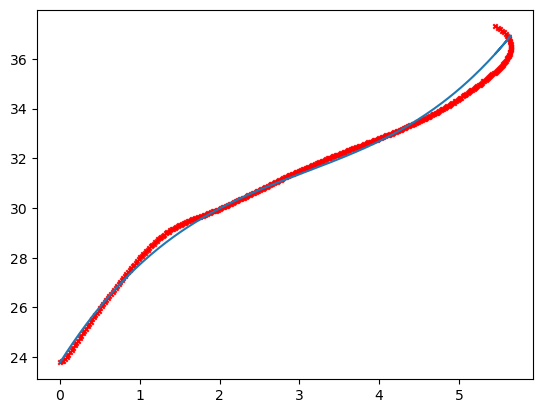

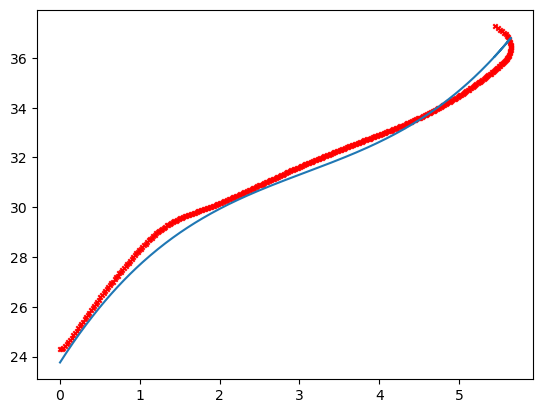

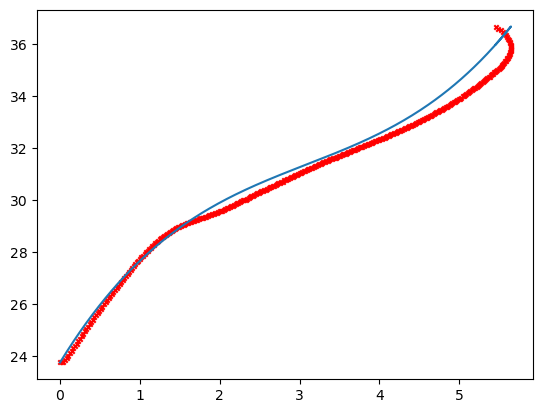

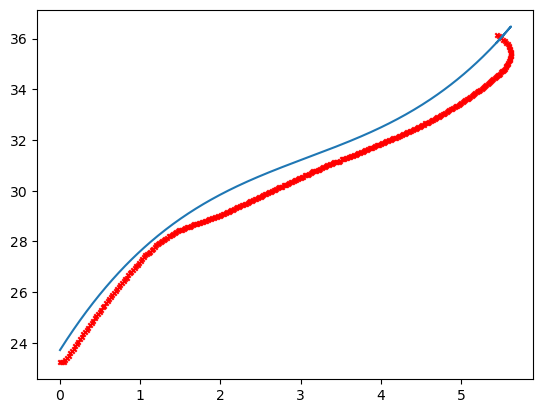

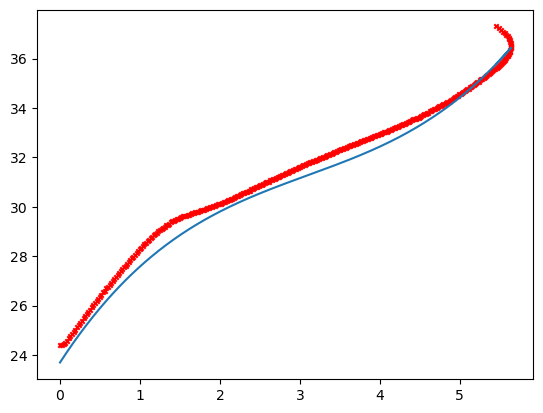

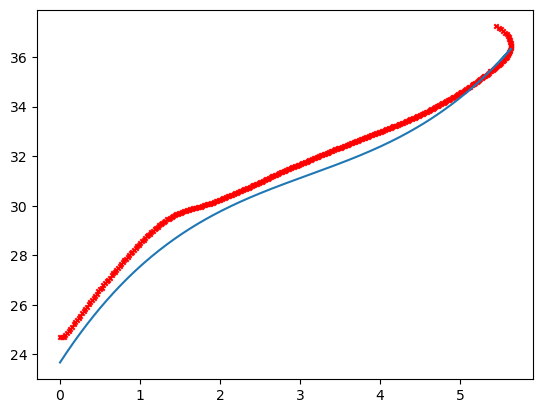

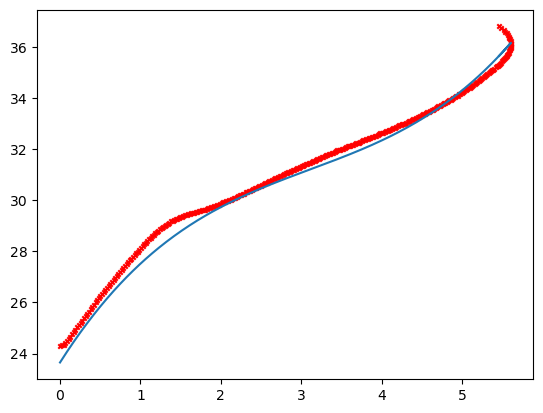

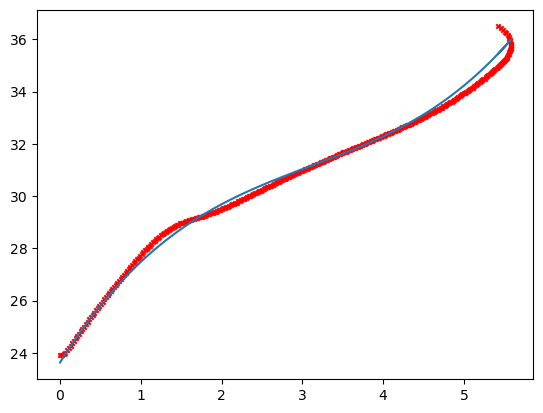

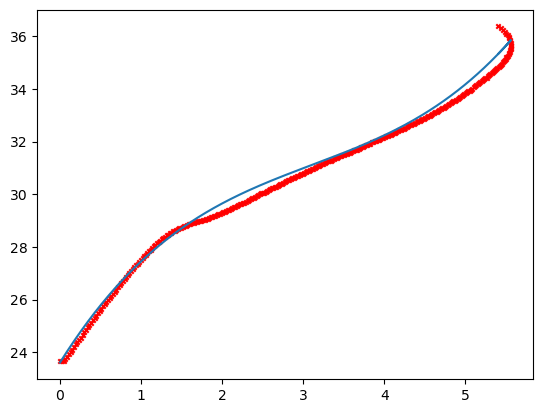

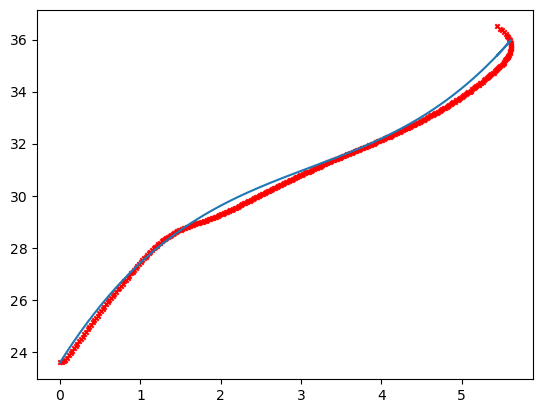

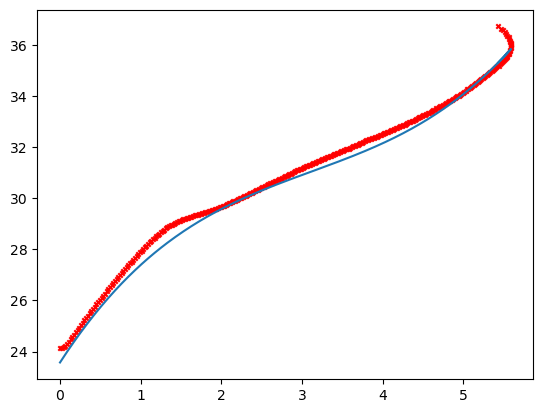

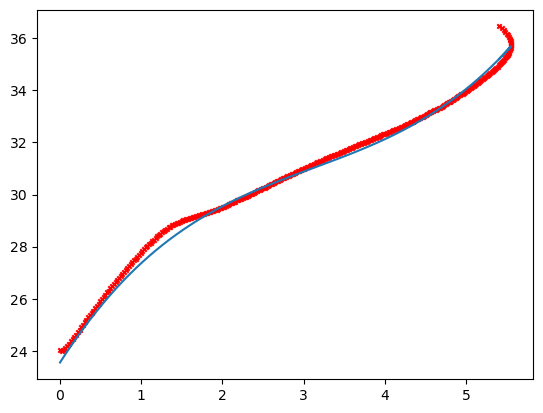

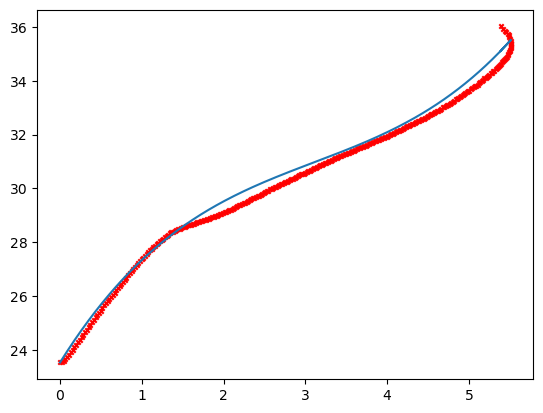

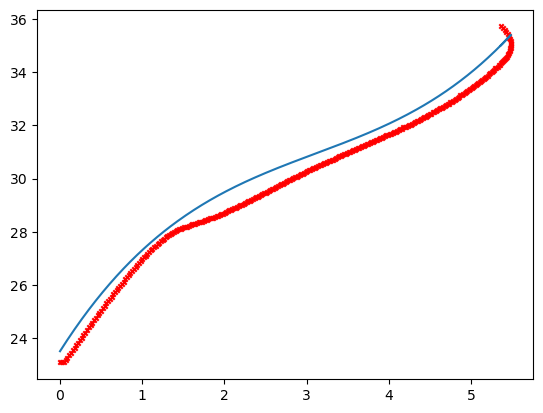

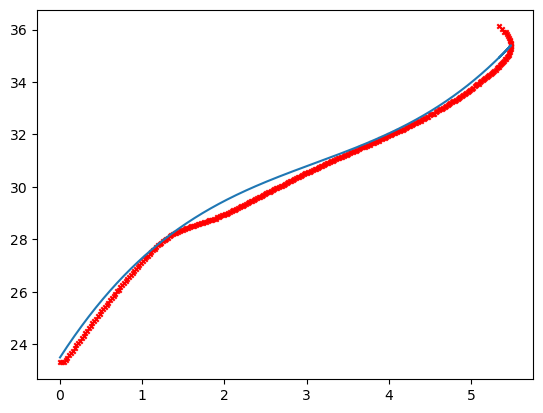

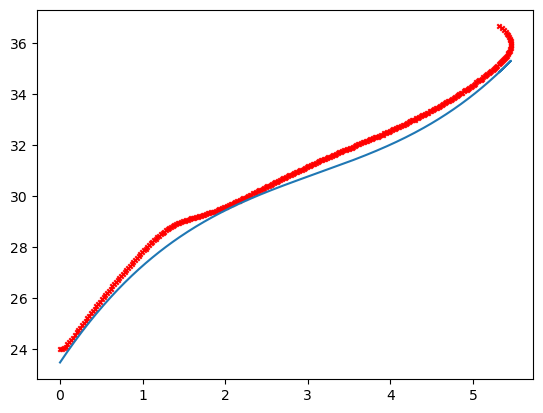

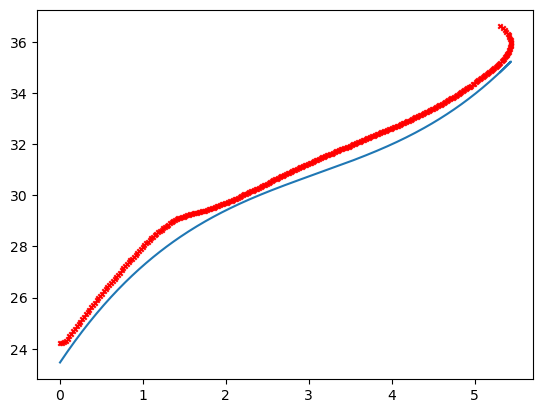

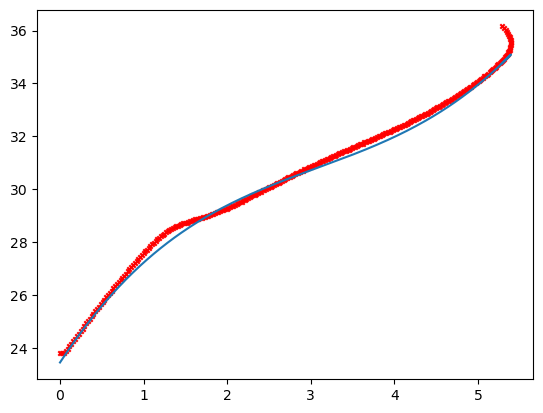

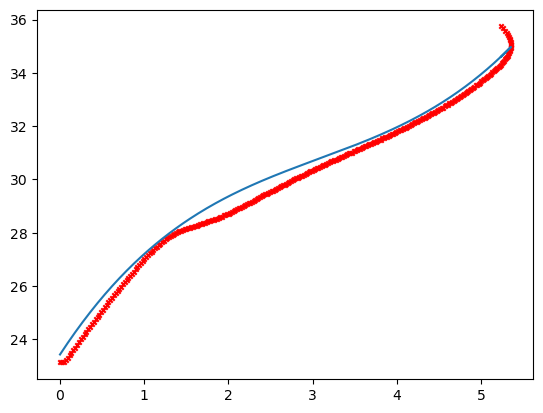

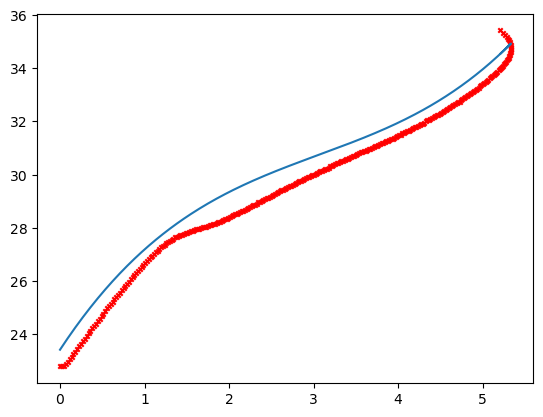

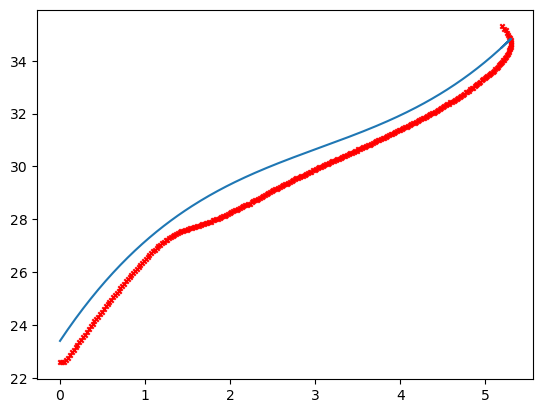

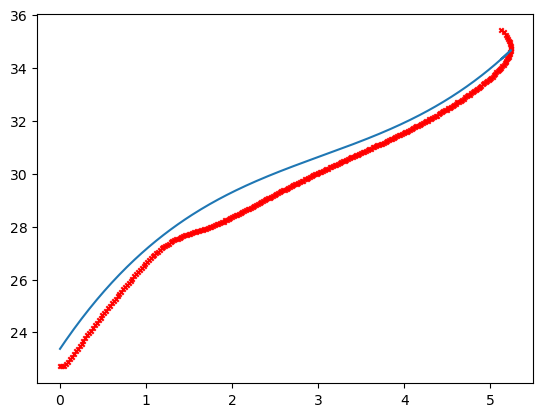

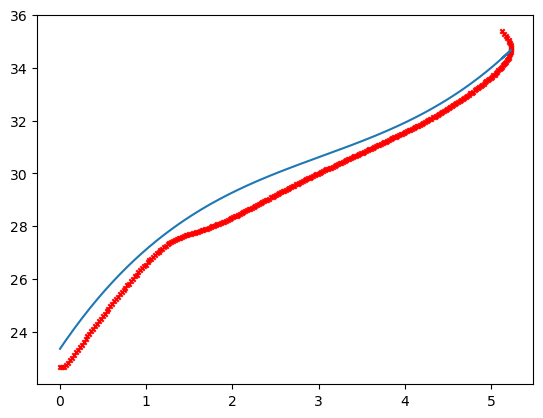

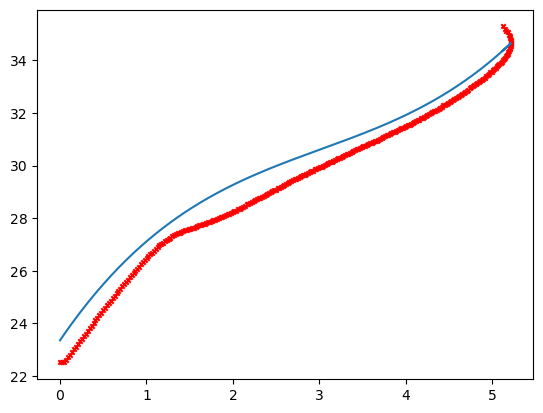

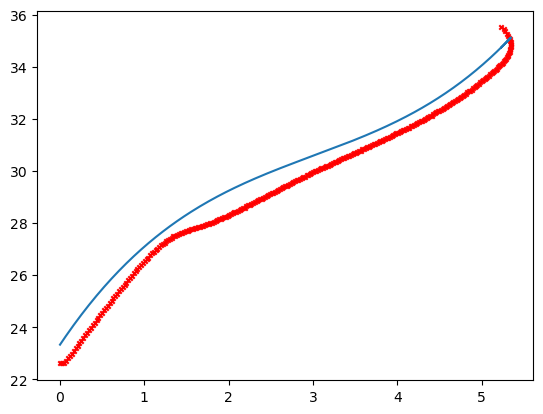

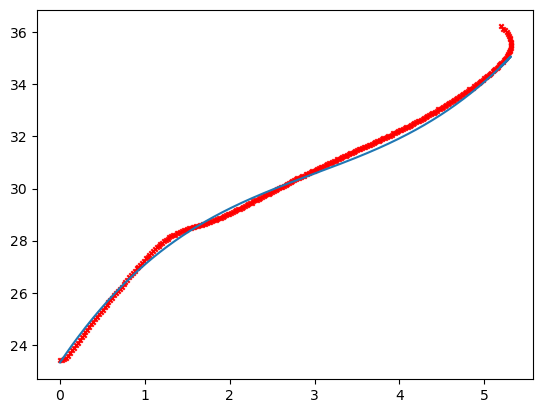

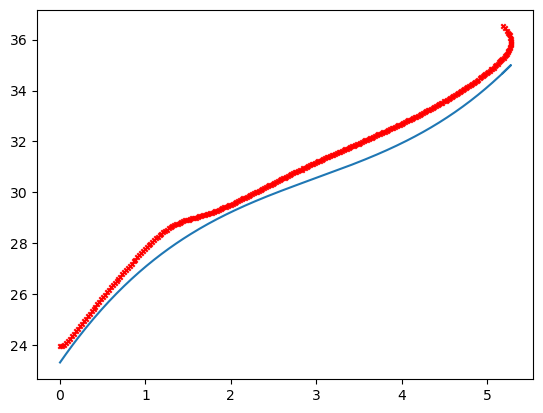

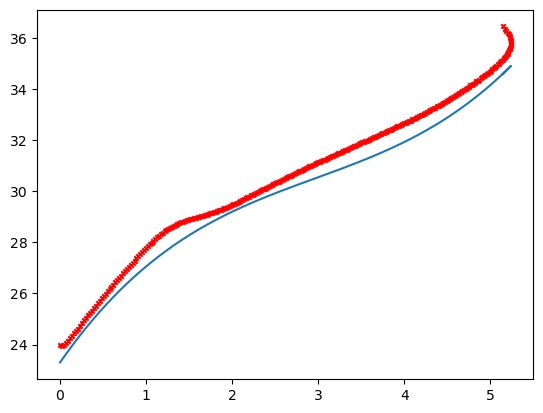

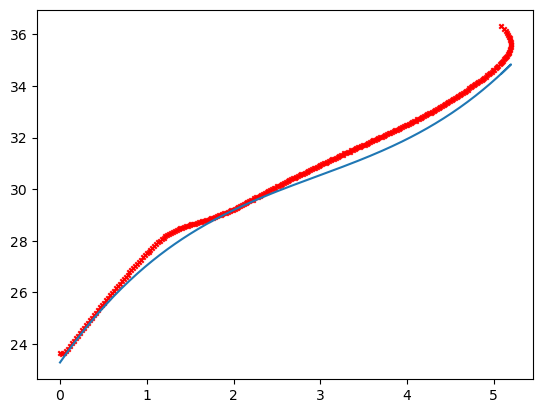

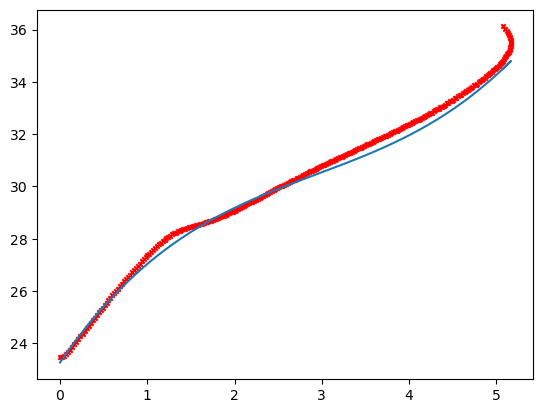

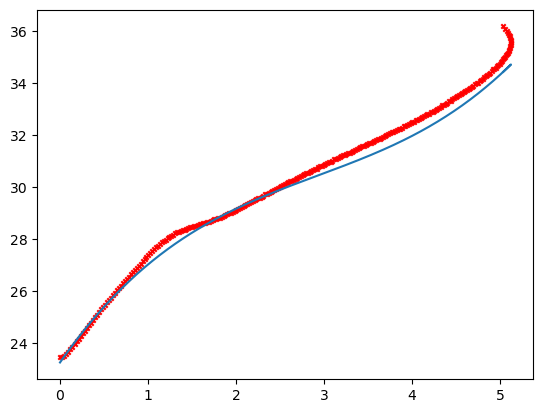

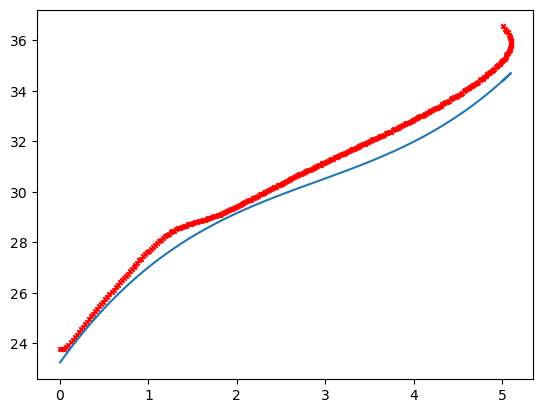

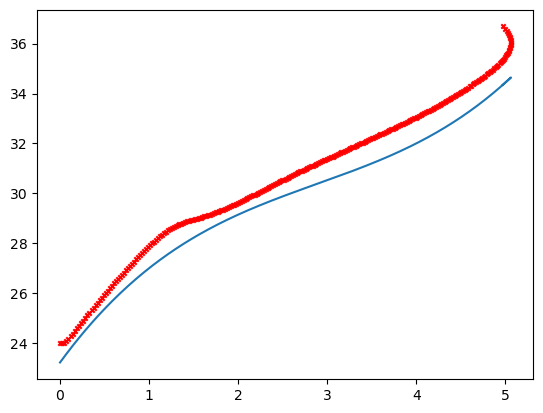

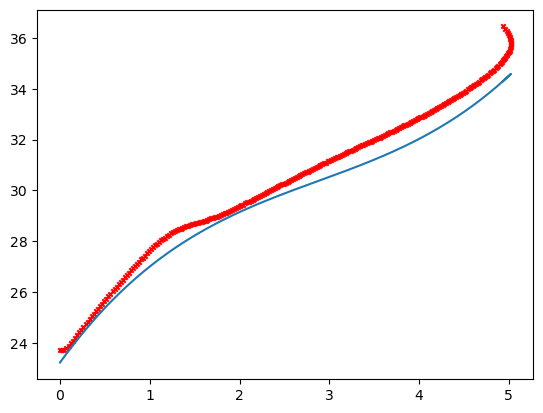

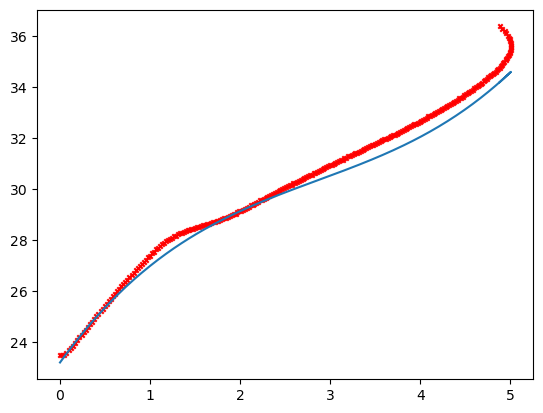

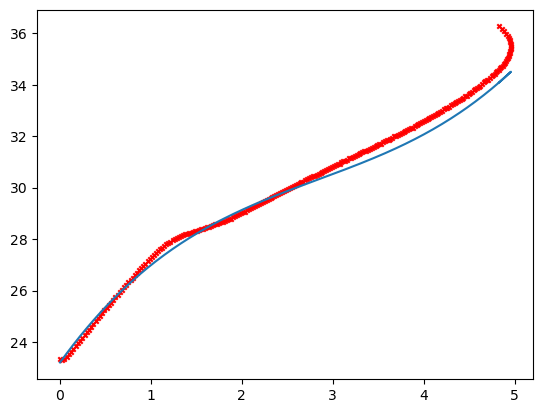

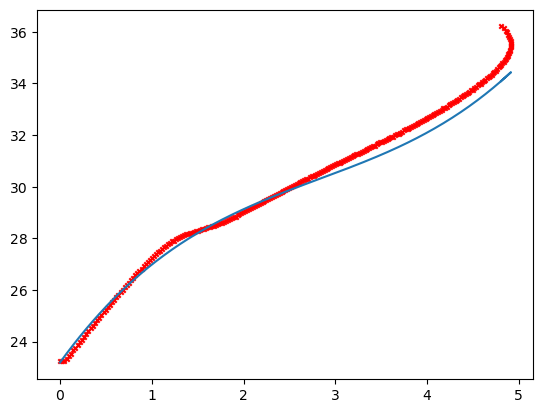

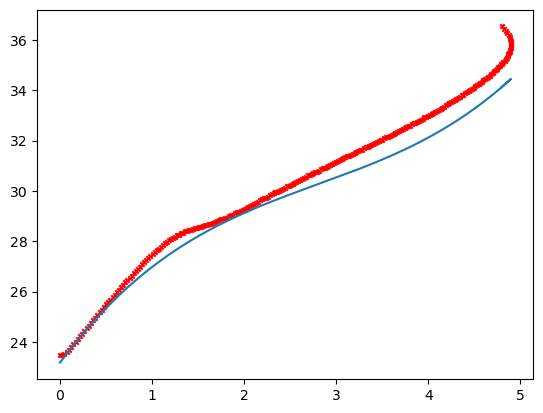

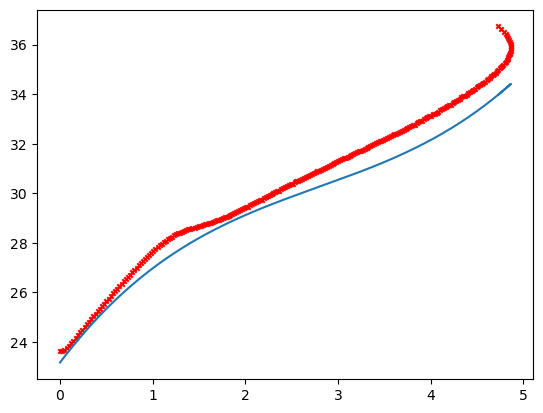

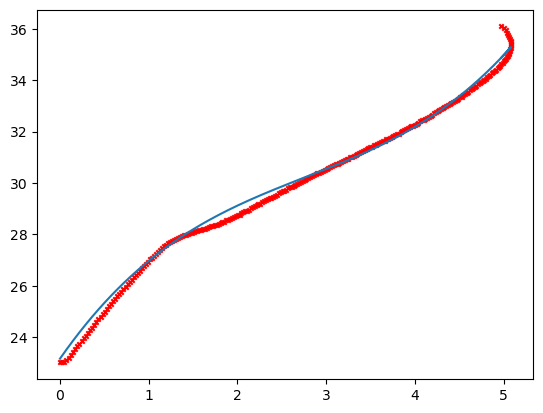

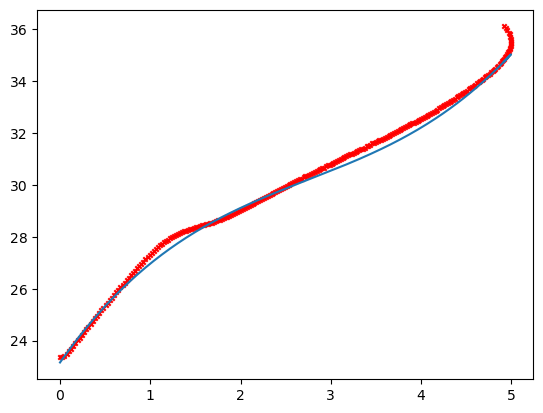

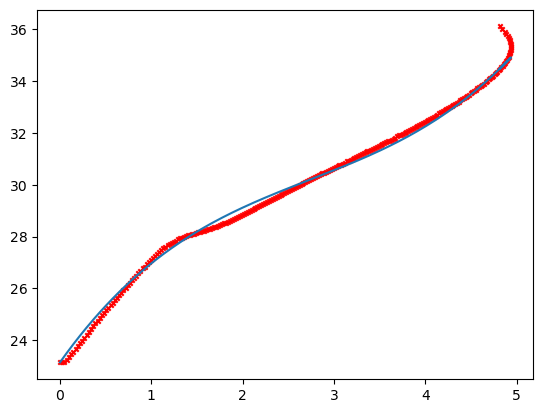

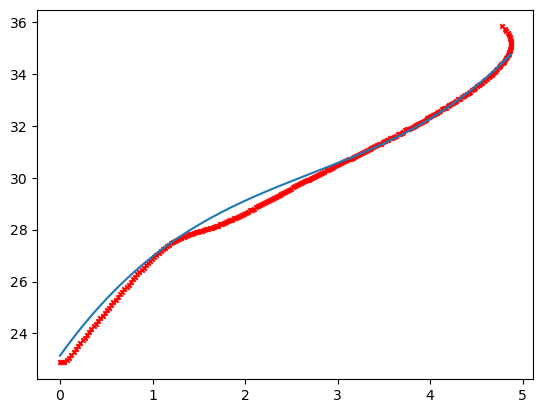

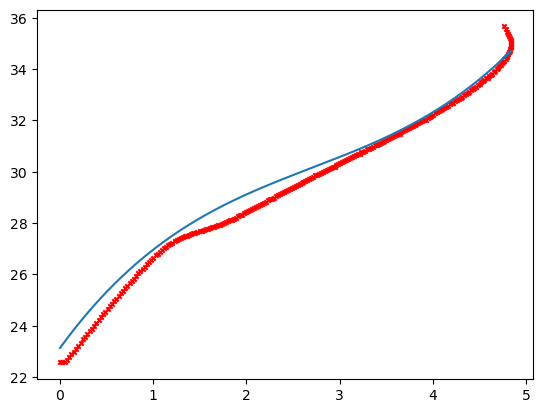

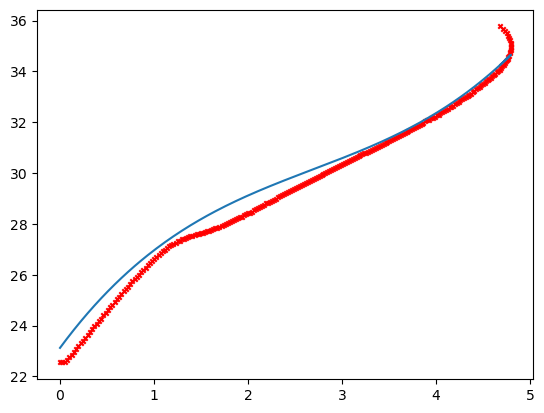

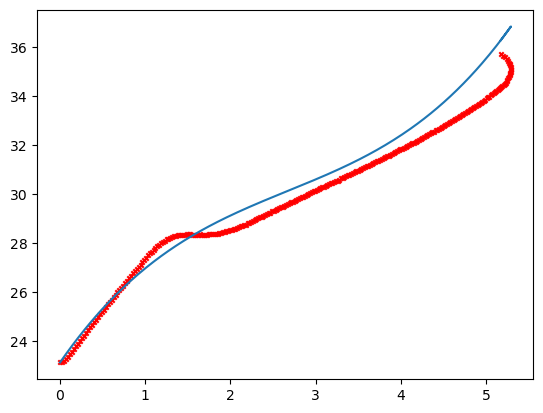

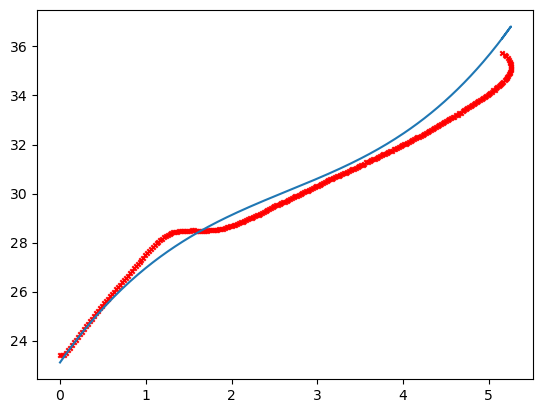

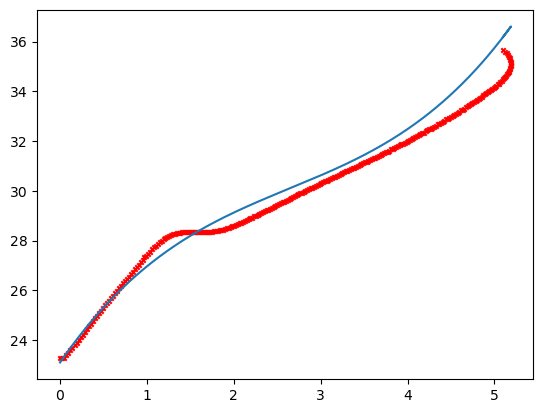

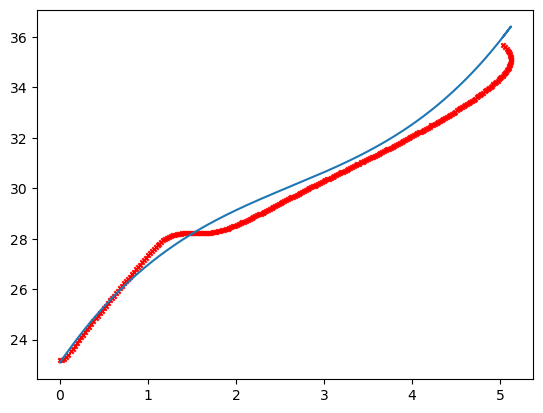

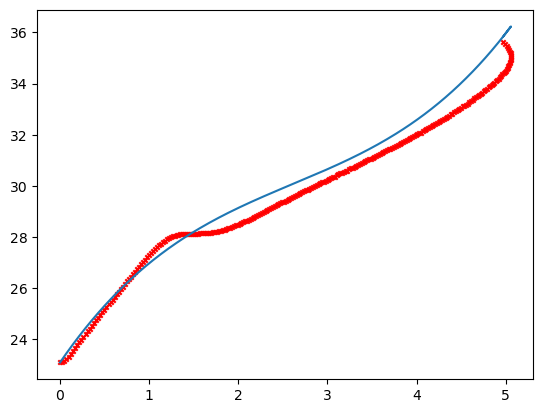

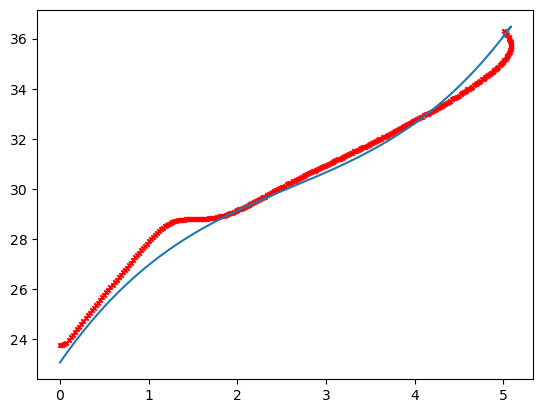

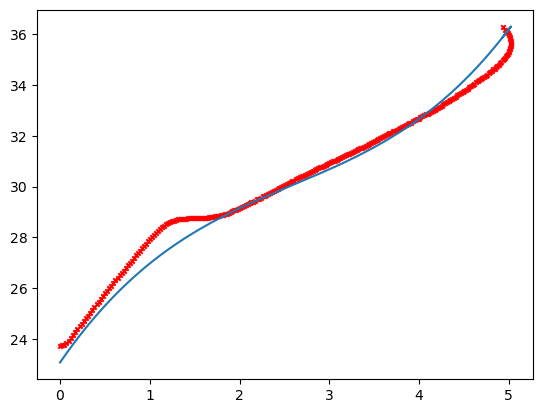

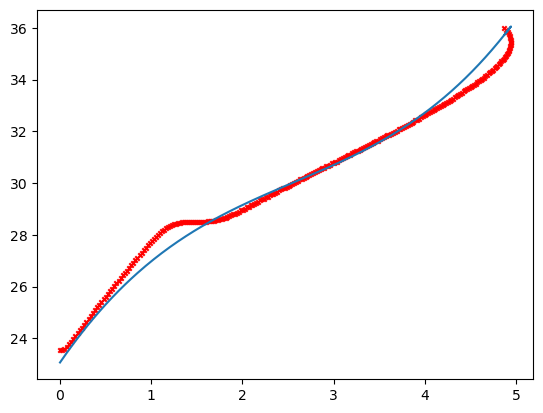

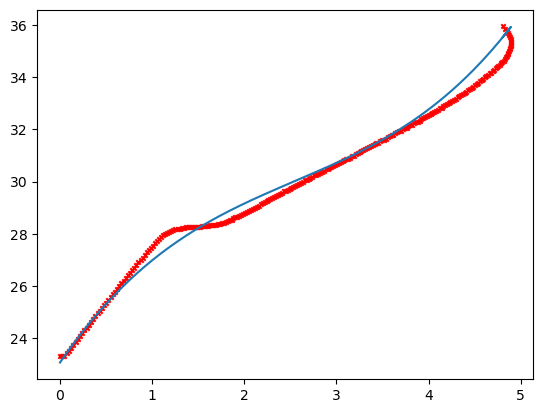

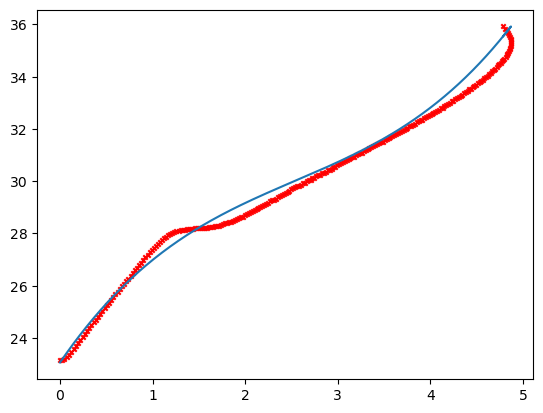

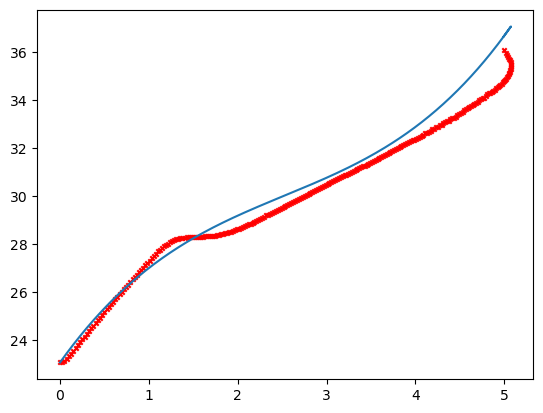

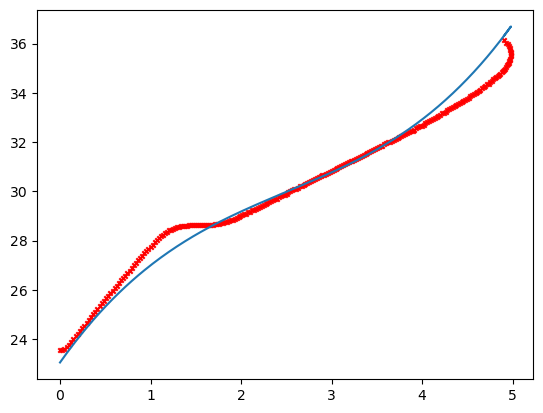

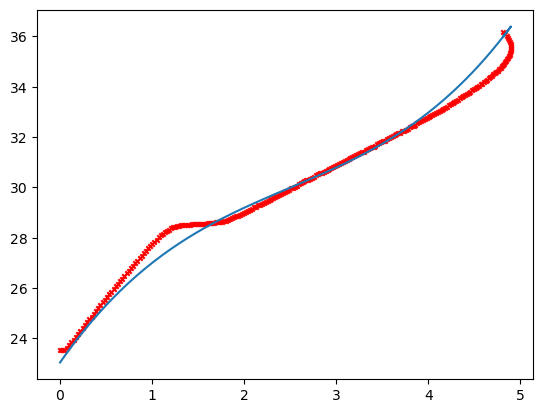

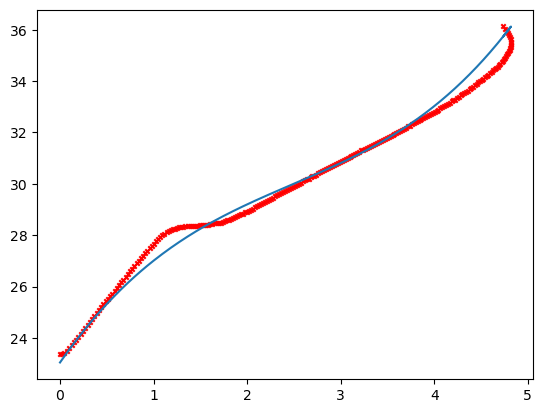

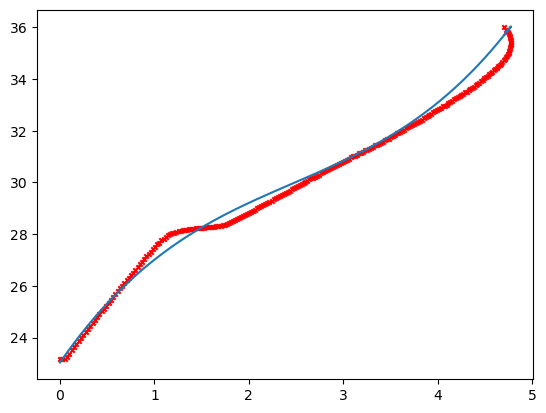

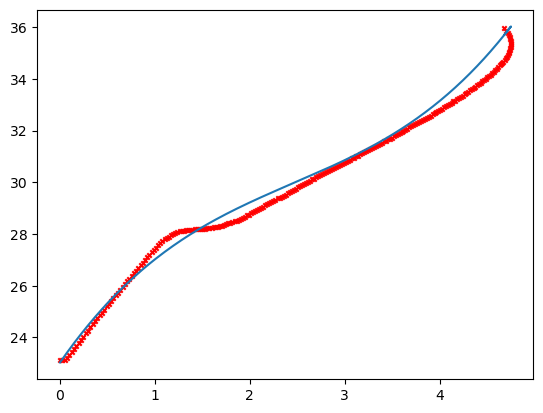

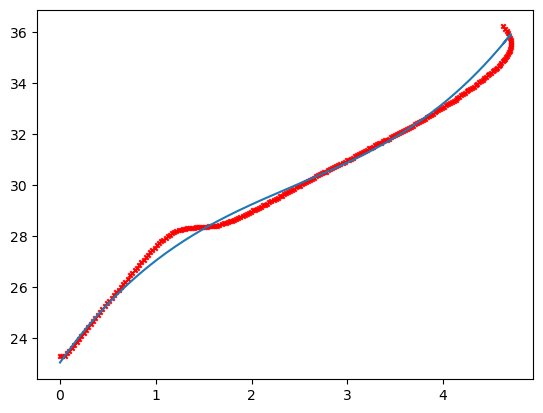

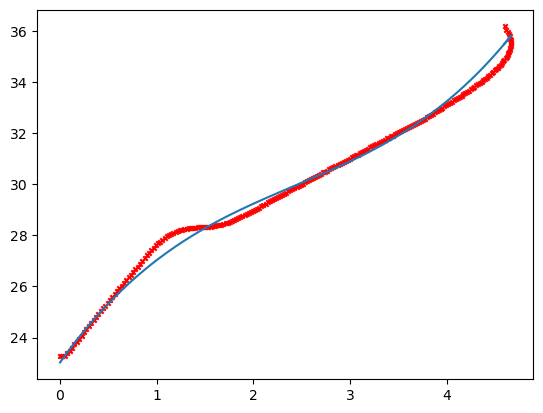

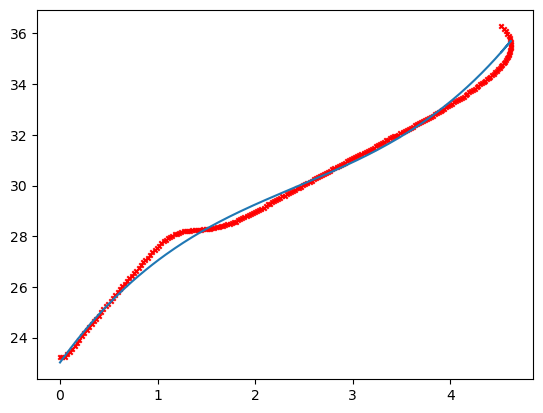

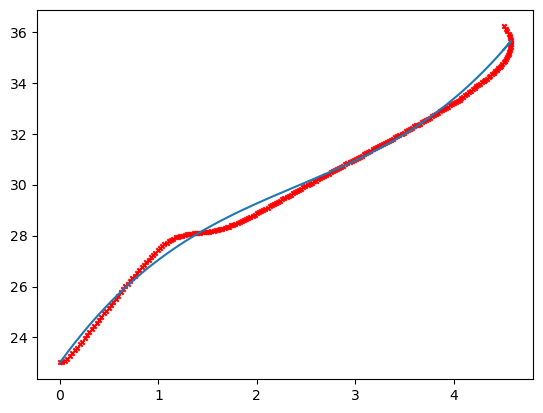

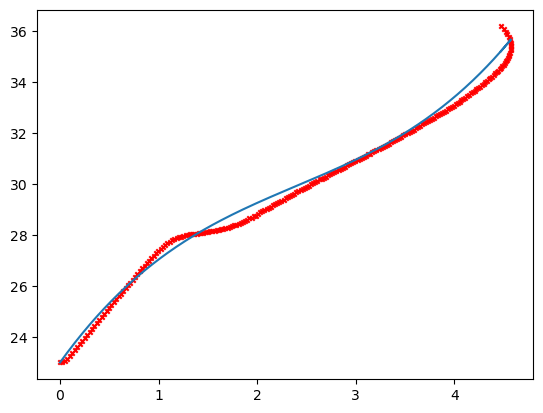

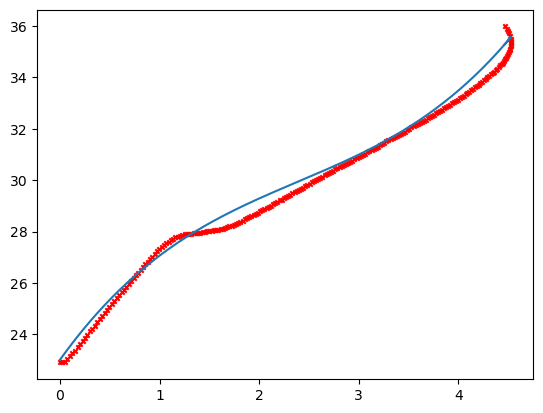

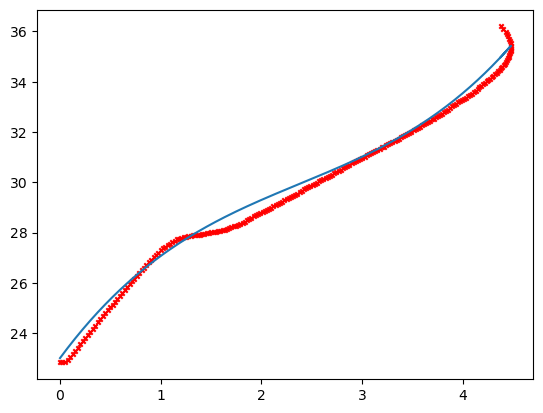

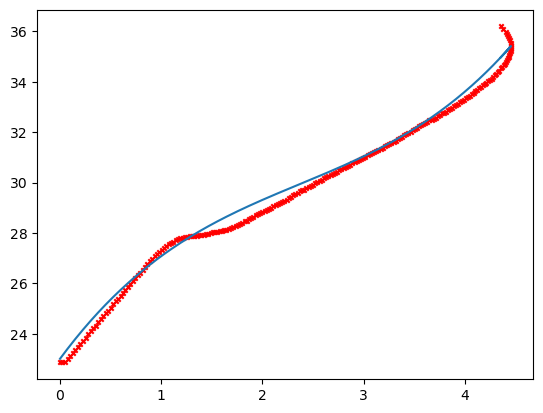

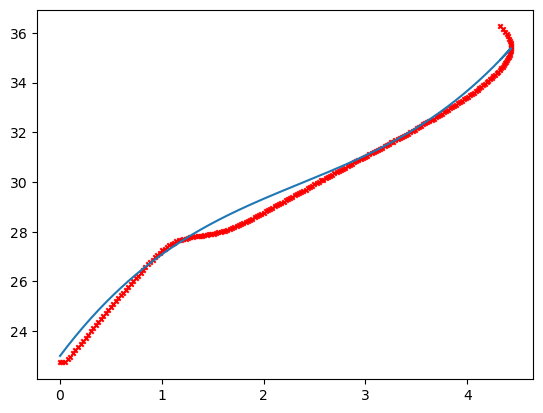

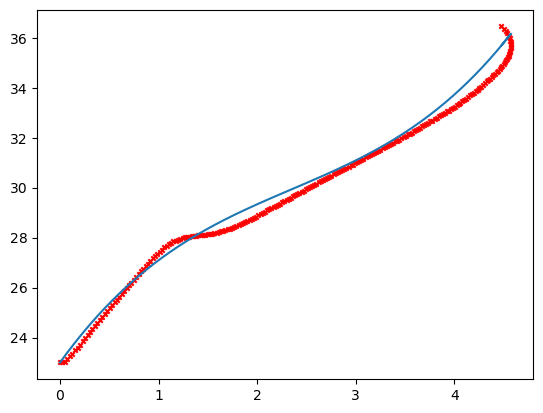

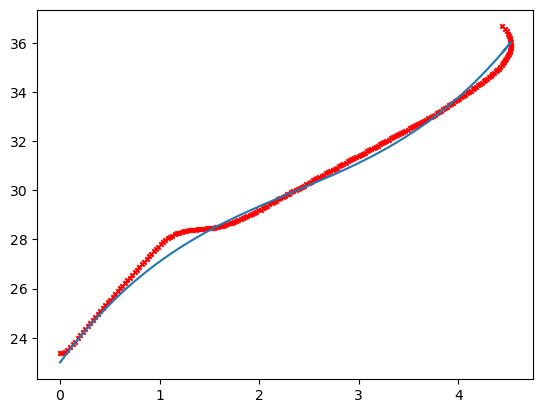

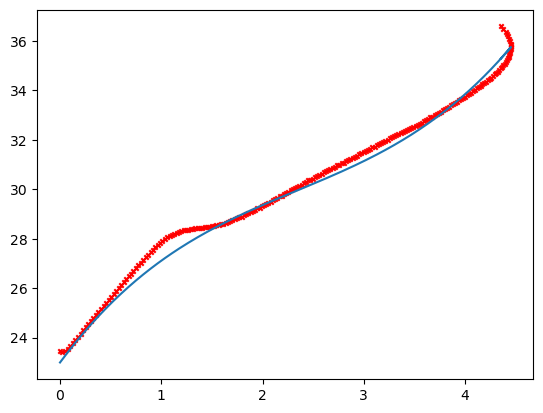

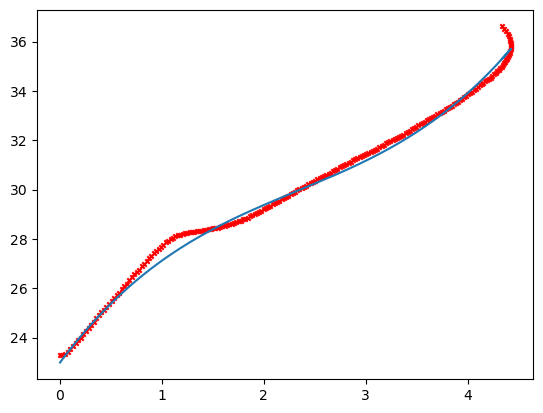

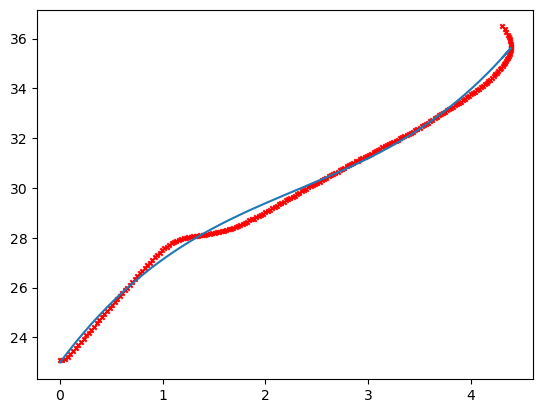

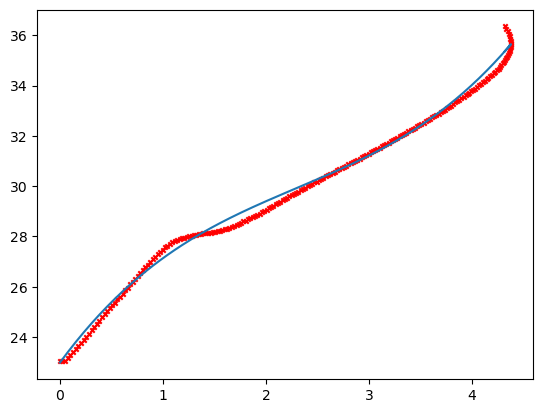

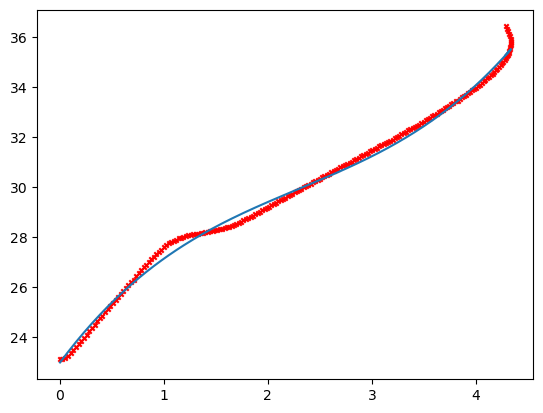

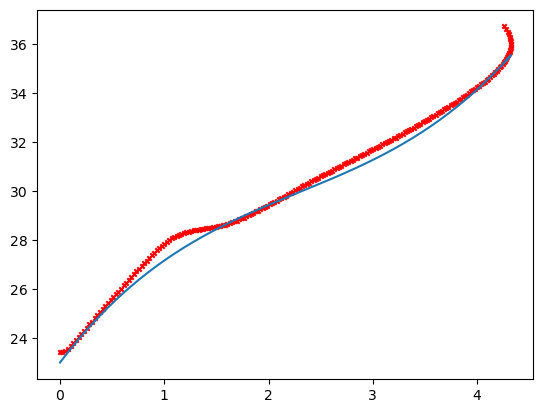

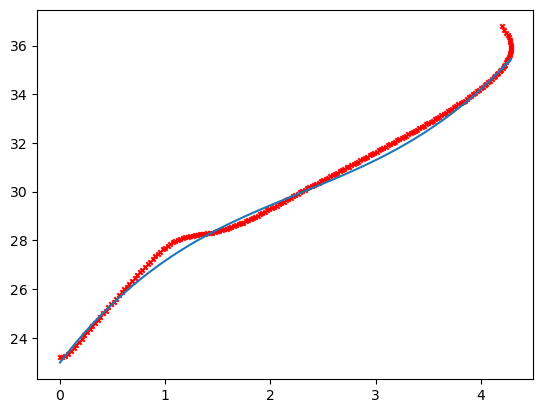

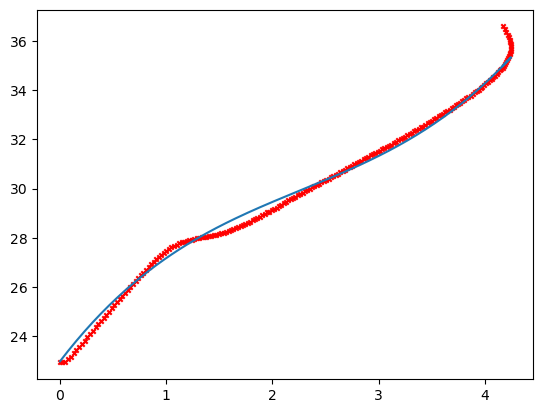

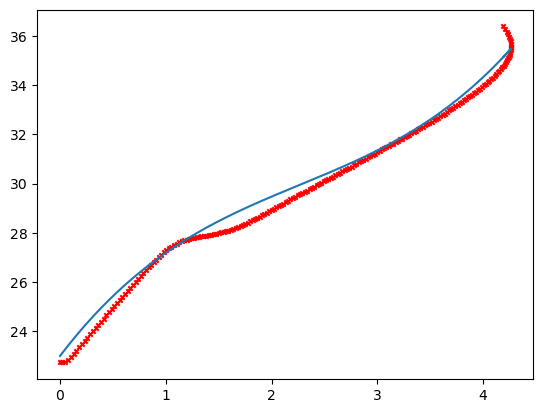

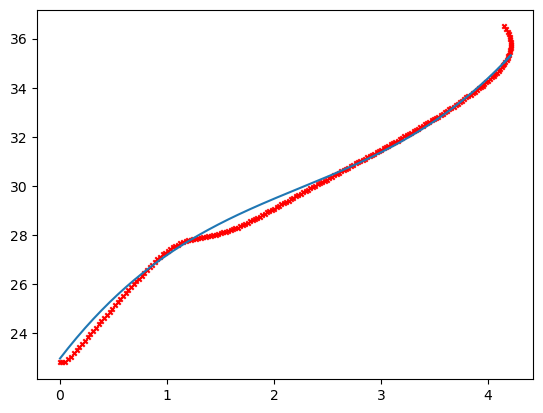

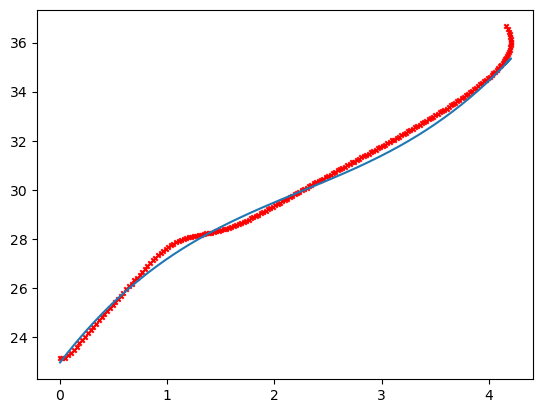

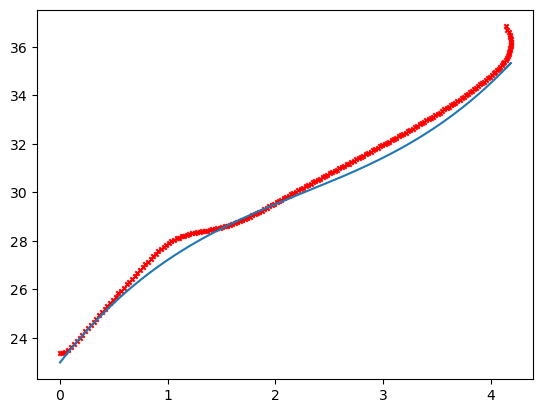

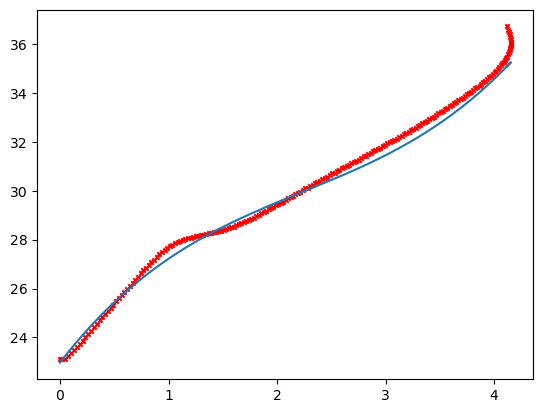

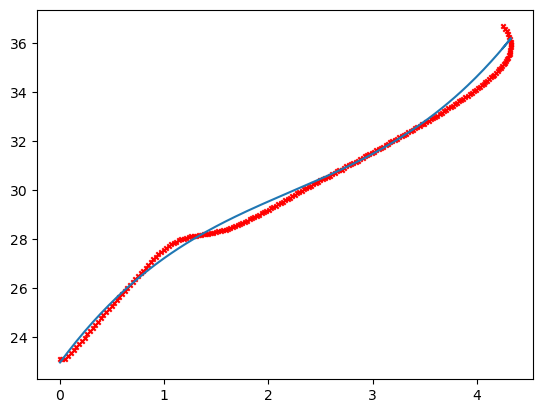

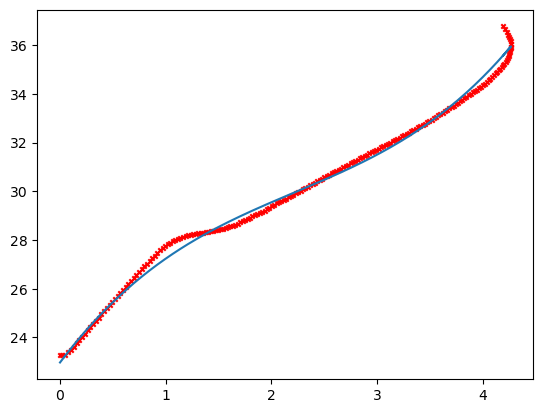

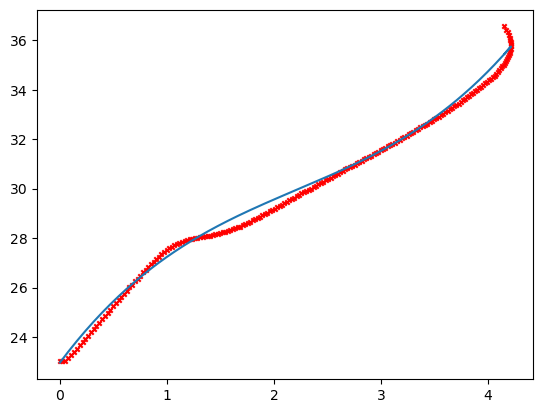

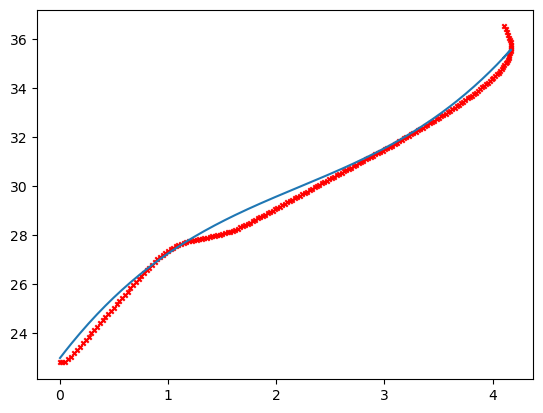

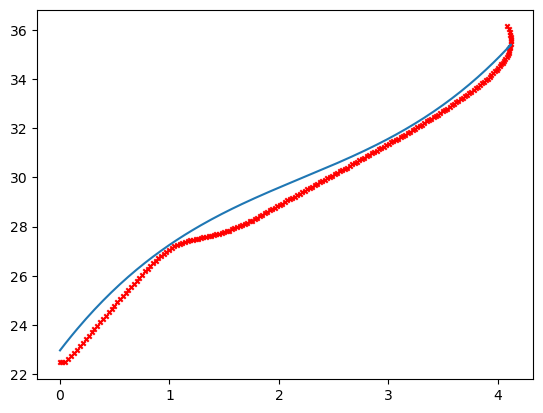

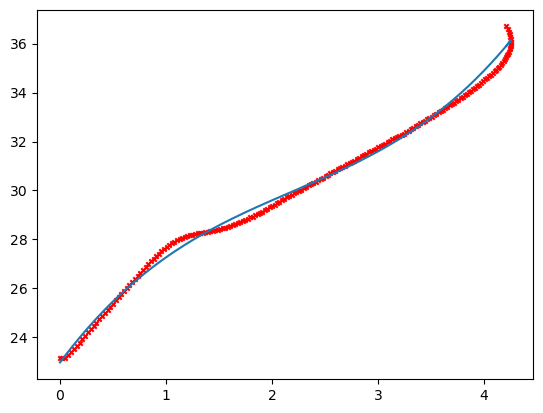

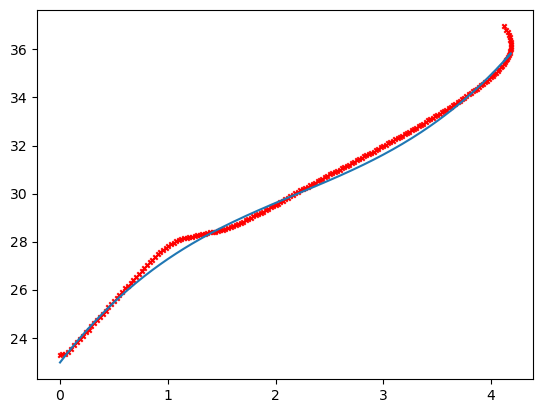

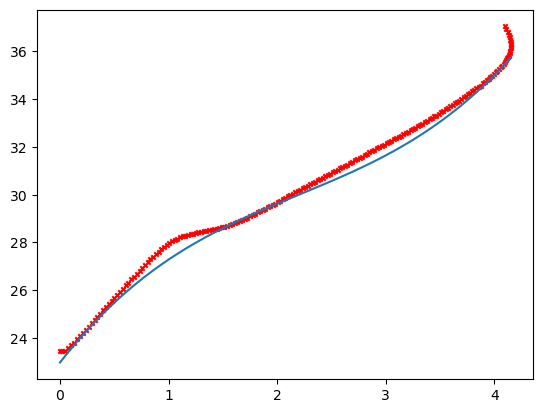

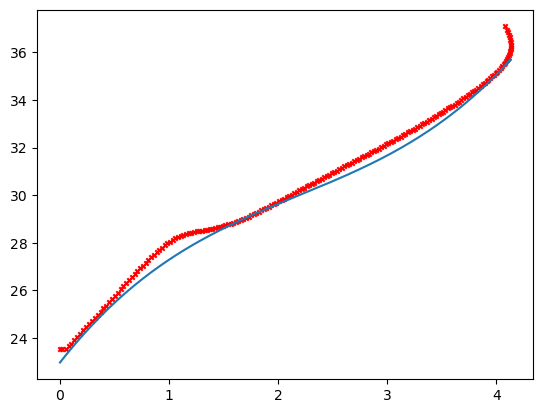

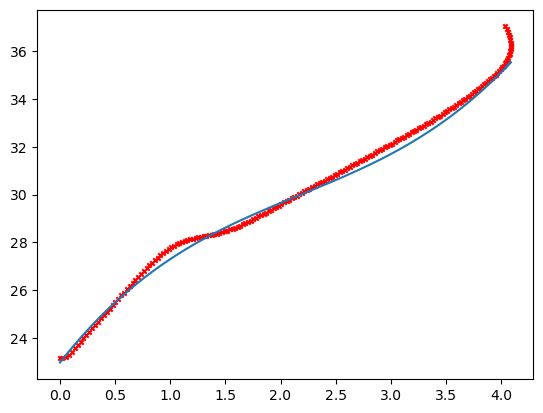

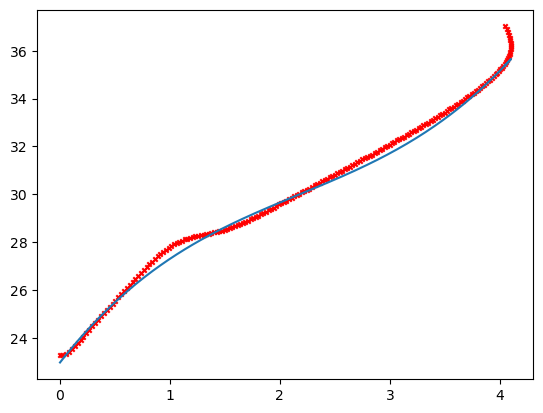

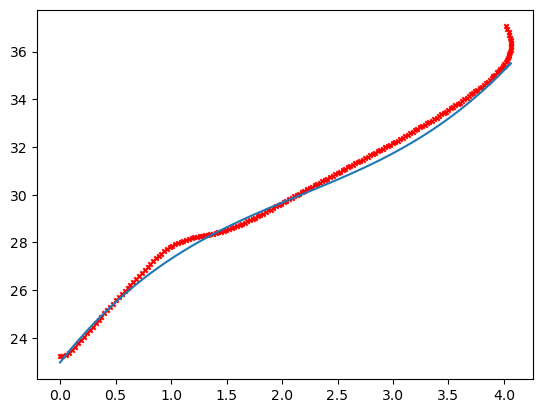

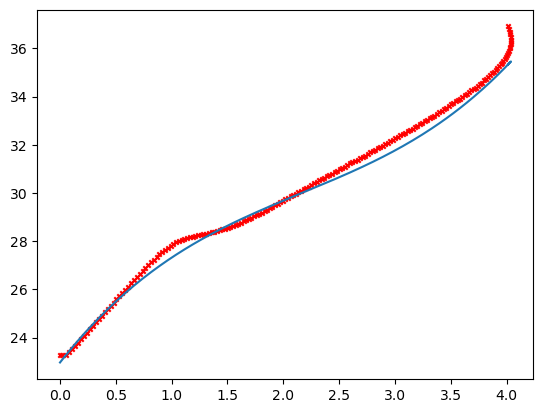

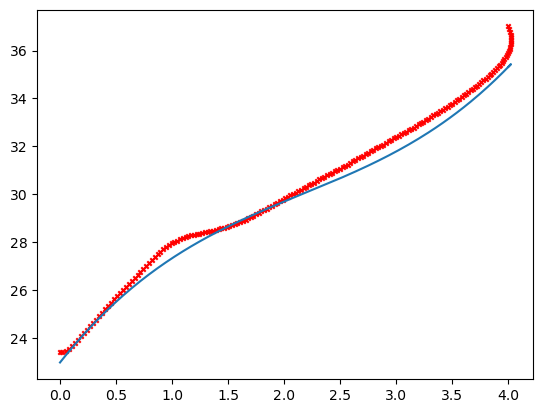

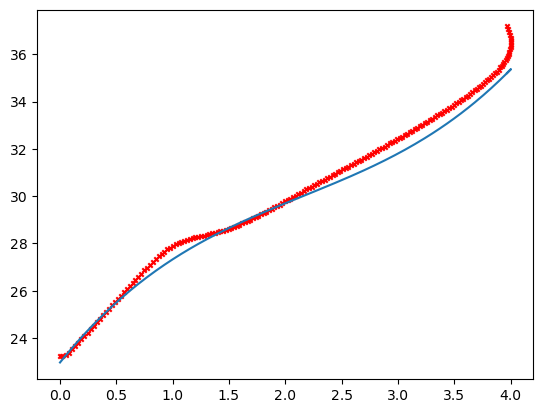

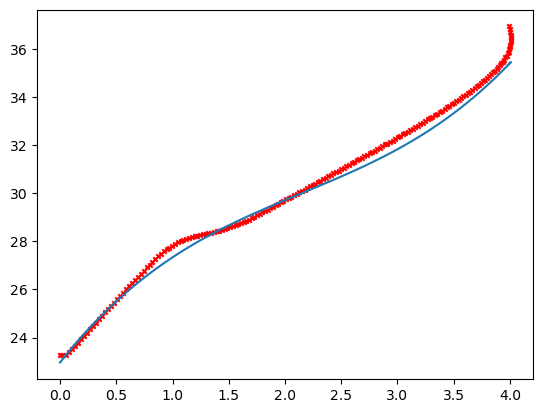

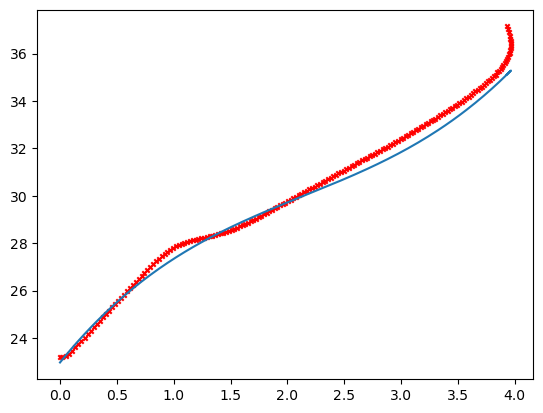

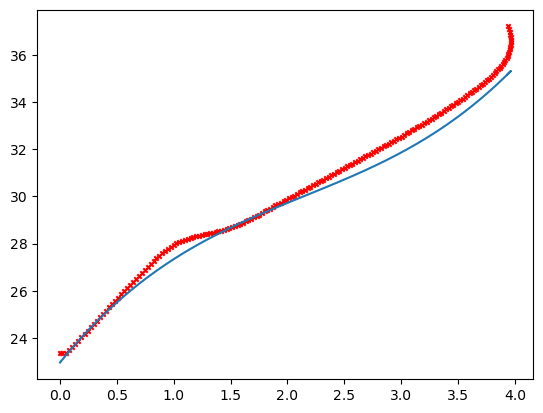

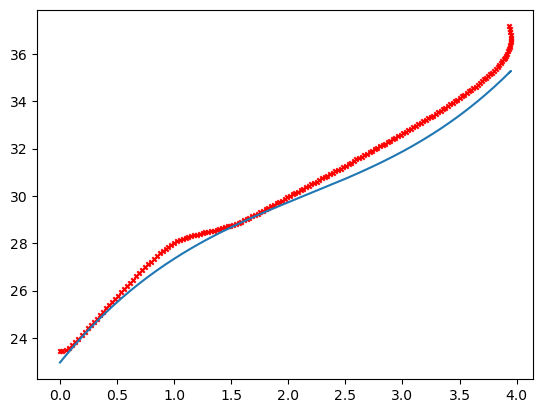

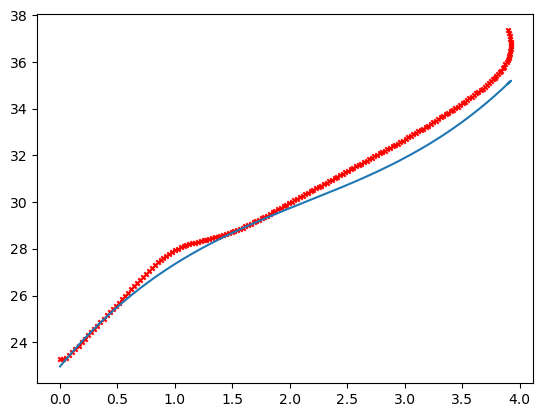

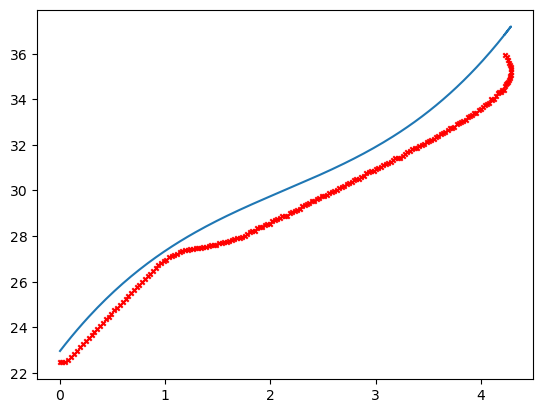

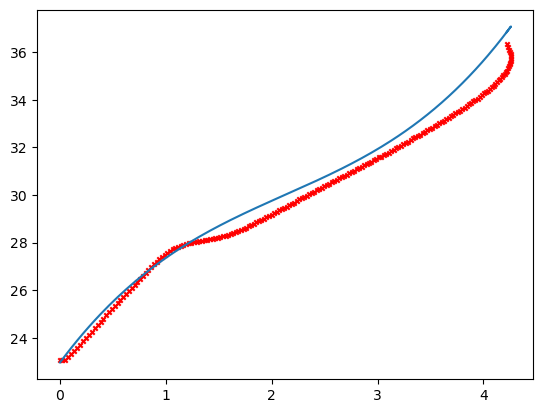

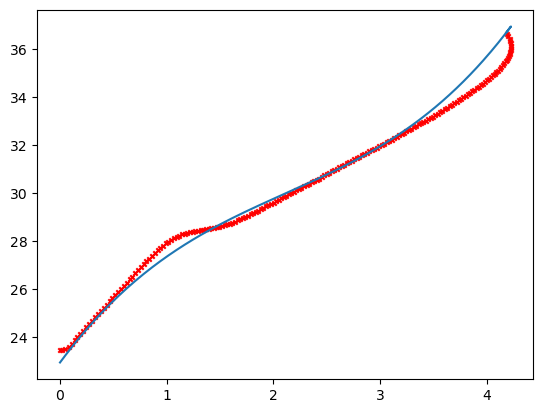

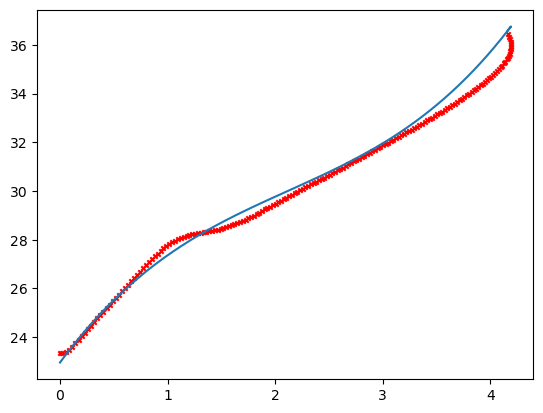

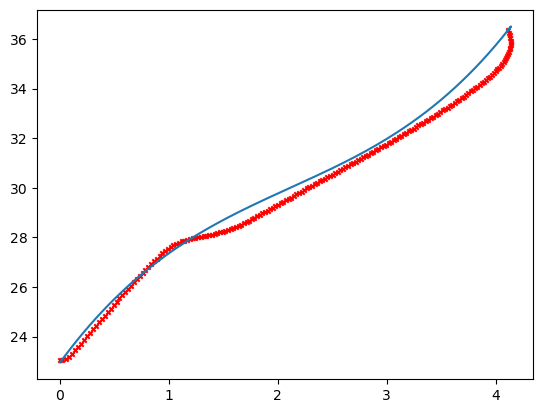

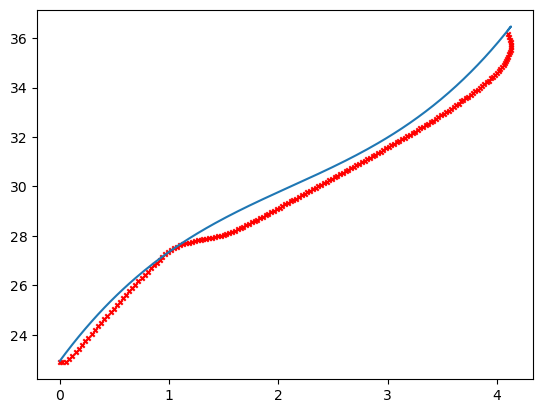

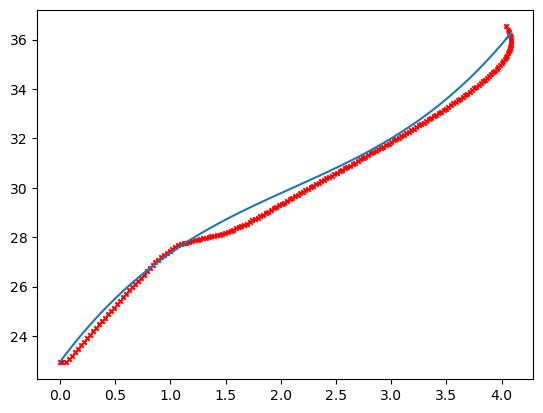

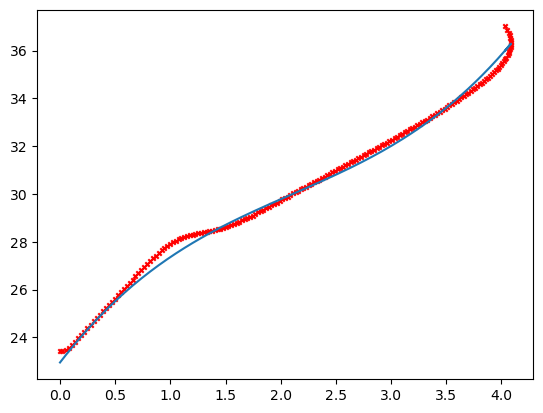

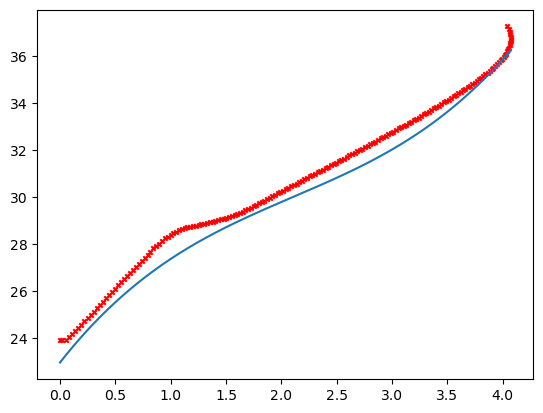

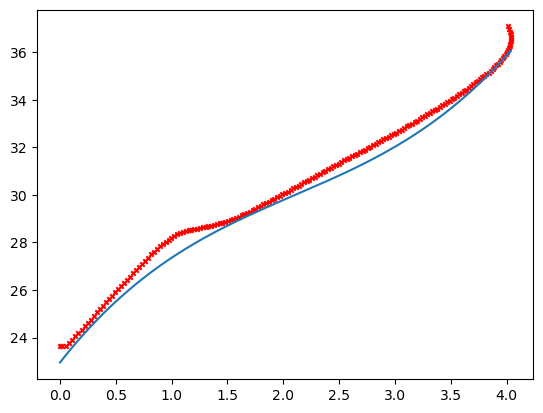

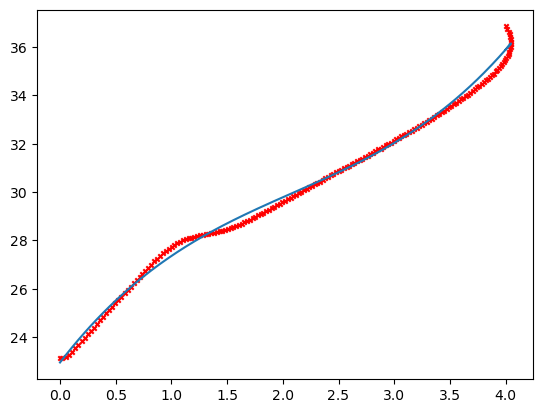

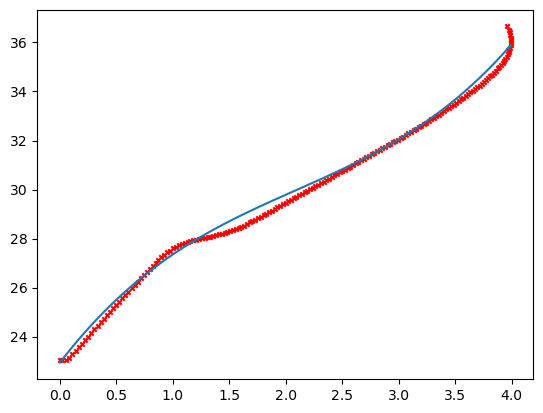

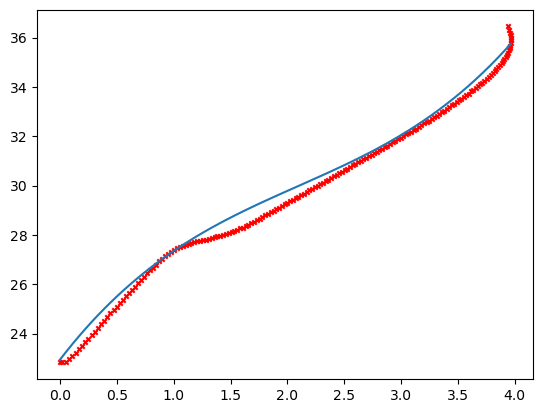

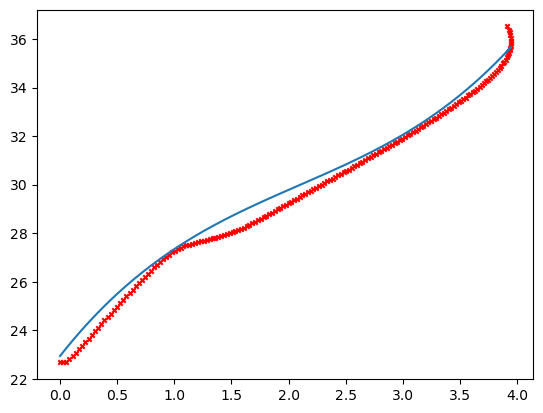

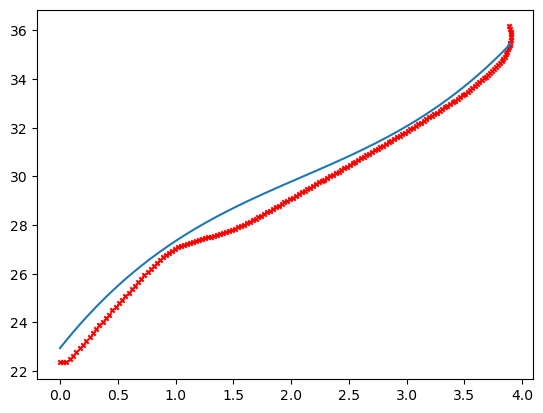

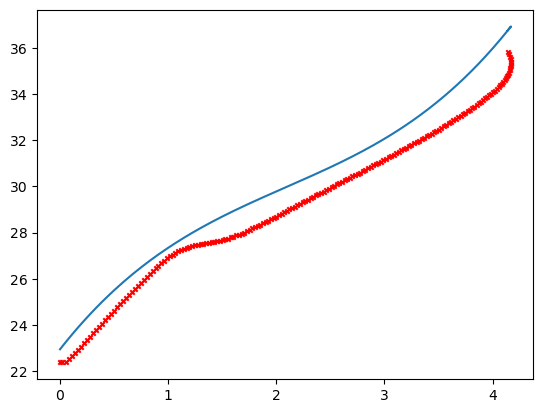

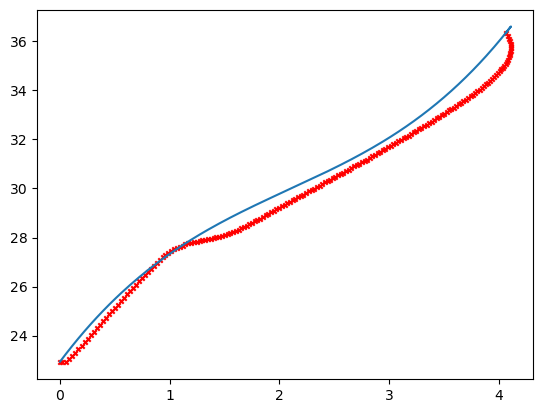

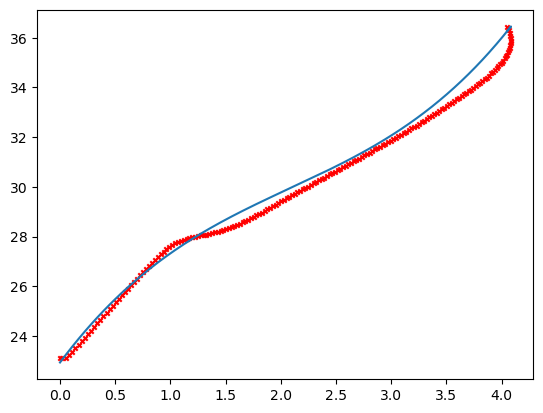

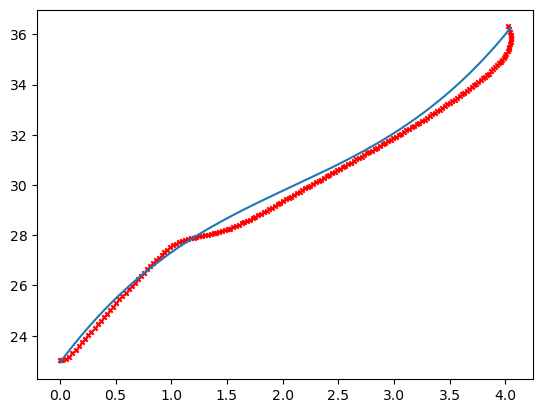

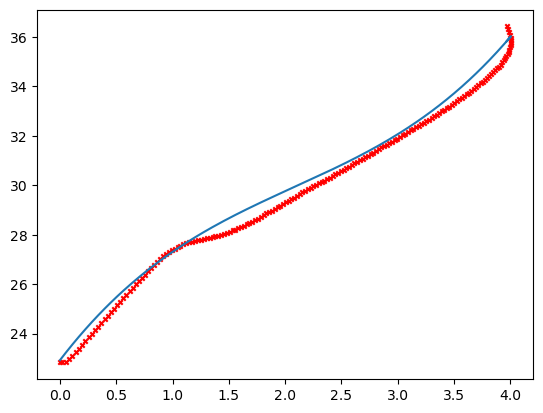

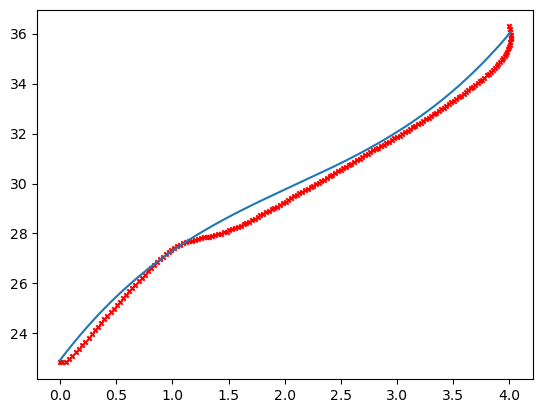

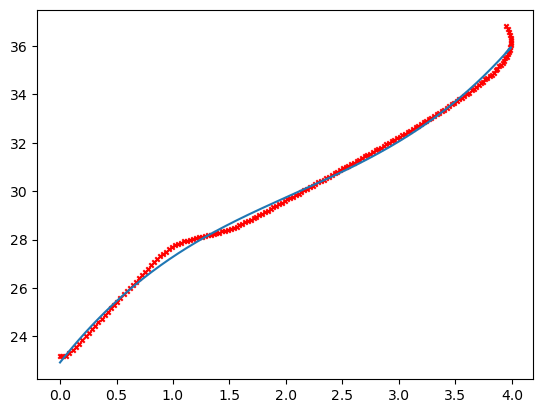

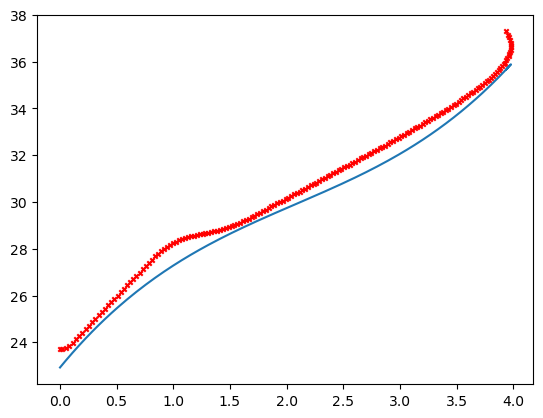

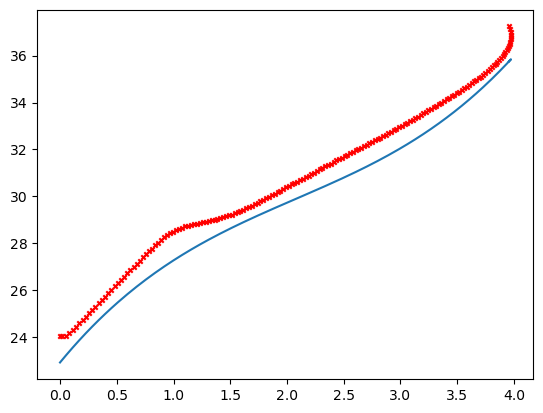

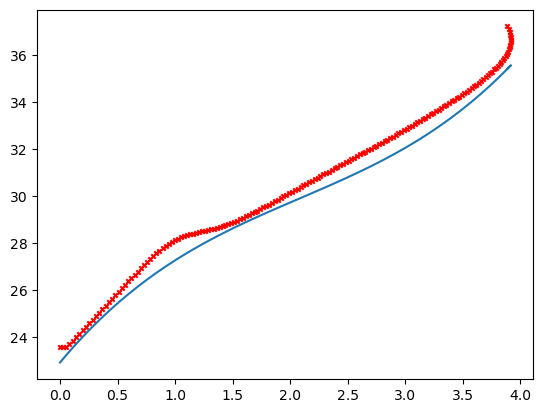

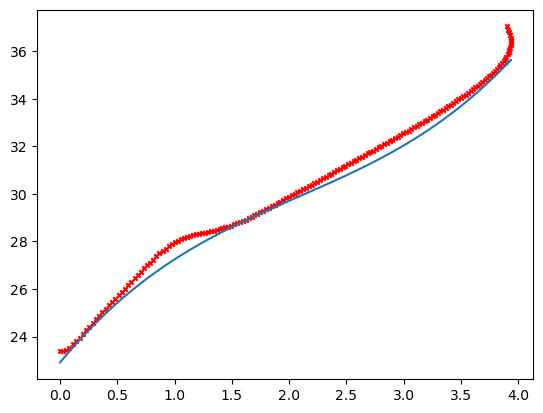

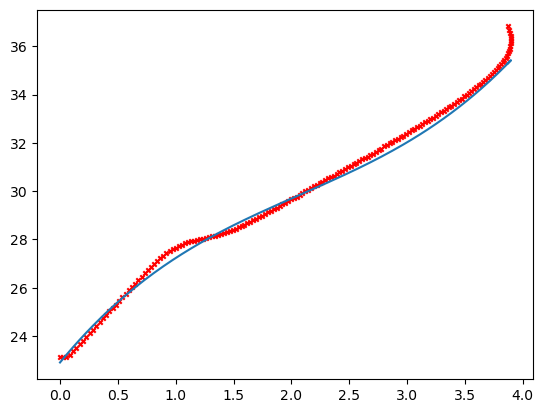

0.04887730672663714 1.6369741462606486


In [10]:
test_results("datasets/battery_18/Discharge", "datasets/battery_18/Temp_Degradation_dynamic.csv")